# Exploratory Data Analysis

In [13]:
import os
from typing import *

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import numpy as np
import statsmodels

%matplotlib inline

plt.style.use("seaborn-v0_8-darkgrid")

PATH = "./data"
SYMBOLS = ["ADA", "BNB", "BTC", "EOS", "ETH", "LTC", "TRX", "VET", "XRP"]


def to_csvf(x):
    return x + "USDT.csv"

In [14]:
def read_file(symbol: str, tf: str, timestamp_unit: str = "ms") -> pd.DataFrame:
    """
    Reads a CSV file, assigns column names, converts the 'date' column to datetime,
    and sets it as the DataFrame's index.

    Parameters
    ----------
    symbol : str
        The symbol.
    tf : str
        The tf.
    timestamp_unit : str, default 'ms'
        The unit of the timestamp in the 'date' column. By default, it's 'ms' (milliseconds).

    Returns
    -------
    pd.DataFrame
        The DataFrame with the 'date' column converted to datetime and set as the index.
    """

    df = pd.read_csv(to_csvf(os.path.join(PATH, tf, symbol)), header=None).iloc[:, 0:6]
    df.columns = ["date", "open", "high", "low", "close", "volume"]
    df["date"] = pd.to_datetime(df["date"], unit=timestamp_unit)
    df.set_index("date", inplace=True)

    return df

In [15]:
def load_data(time_frame: str) -> dict:
    """Load data for all symbols and a given time frame."""
    data = {}
    for symbol in SYMBOLS:
        data[symbol] = read_file(symbol, time_frame)
    return data


daily_data = load_data("1d")
hourly_data = load_data("1h")

In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

PATH = "./data"
SYMBOLS = ["ADA", "BNB", "BTC", "EOS", "ETH", "LTC", "TRX", "VET", "XRP"]

def read_file(symbol: str, tf: str, timestamp_unit: str = "ms") -> pd.DataFrame:
    """
    Reads a CSV file, assigns column names, converts the 'date' column to datetime,
    and sets it as the DataFrame's index.

    Parameters
    ----------
    symbol : str
        The symbol.
    tf : str
        The tf.
    timestamp_unit : str, default 'ms'
        The unit of the timestamp in the 'date' column. By default, it's 'ms' (milliseconds).

    Returns
    -------
    pd.DataFrame
        The DataFrame with the 'date' column converted to datetime and set as the index.
    """

    df = pd.read_csv(to_csvf(os.path.join(PATH, tf, symbol)), header=None).iloc[:, 0:6]
    df.columns = ["date", "open", "high", "low", "close", "volume"]
    df["date"] = pd.to_datetime(df["date"], unit=timestamp_unit)
    df.set_index("date", inplace=True)

    return df

def create_input_tensor(data, lookback=250*24):
    inputs = []
    for i in range(0, len(data) - lookback, 24):
        inputs.append(data.iloc[i:i+lookback].values)
        # print(data.iloc[i+lookback])
        
    return np.array(inputs)

def create_target_tensor(data_dict):
    # Step 1: Create a dataframe with closing prices for each currency
    close_prices_df = pd.DataFrame({symbol: df['close'] for symbol, df in data_dict.items()}).dropna()
    # Step 2: Repeat each value three times
    # print(close_prices_df)
    target_array = np.array(close_prices_df.apply(lambda x: np.array([item for item in x for _ in range(3)]), axis=1).values)

    return np.vstack(target_array)
    
def prepare_data(PATH):
    # 1. Read BTC hourly data
    btc_data = read_file("BTC", "1h")
    # Create a new index to fill missing values
    full_index = pd.date_range(btc_data.index.min(), btc_data.index.max(), freq="H")
    df_full = pd.DataFrame(index=full_index)
    # Create the new dataframe forwarding missing values
    btc_data = df_full.merge(btc_data, left_index=True, right_index=True, how='left').fillna(method='ffill')
    # 2. Read other currencies' daily data
    daily_data = {}
    for symbol in SYMBOLS:
        if symbol != "BTC":
            daily_data[symbol] = read_file(f"{symbol}", "1d")

    # 3. Find overlapping date range
    min_date = btc_data.index.min()
    max_date = btc_data.index.max()
    for df in daily_data.values():
        min_date = max(min_date, df.index.min())
        max_date = min(max_date, df.index.max())

    # 4. Prune each dataset to the overlapping range
    btc_data = btc_data.loc[min_date - pd.Timedelta(days=250, hours=1):max_date - pd.Timedelta(hours=1)]
    for symbol in daily_data:
        daily_data[symbol] = daily_data[symbol].loc[min_date:max_date]
    # 5. Scale the BTC data and each feature separately
    scalers_btc = {}
    for col in btc_data.columns:
        scaler = MinMaxScaler()
        btc_data[col] = scaler.fit_transform(btc_data[col].values.reshape(-1, 1))
        scalers_btc[col] = scaler

    # Create input tensor from scaled BTC hourly data
   
    input_tensor = create_input_tensor(btc_data)
     # 6. Scale target data (Close Price) for each currency
    scalers_targets = {}
    scaled_targets = {}
    for symbol, df in daily_data.items():
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df["close"].values.reshape(-1, 1))
        scaled_targets[symbol] = pd.DataFrame(scaled_data, columns=["close"], index=df.index)  # Save the scaled data as dataframe
        scalers_targets[symbol] = scaler
    # Create target tensor using scaled data
    target_tensors = create_target_tensor(scaled_targets)

    return input_tensor, target_tensors, scalers_btc, scalers_targets
# Use the function
input_data, target_data, btc_scalers, target_scalers = prepare_data(PATH)
input_data.shape

(1840, 6000, 5)

In [17]:
btc_data = read_file("BTC", "1h")
# 2. Read other currencies' daily data
daily_data = {}
for symbol in SYMBOLS:
    if symbol != "BTC":
        daily_data[symbol] = read_file(f"{symbol}", "1d")

# 3. Find overlapping date range
min_date = btc_data.index.min()
max_date = btc_data.index.max()
for df in daily_data.values():
    min_date = max(min_date, df.index.min())
    max_date = min(max_date, df.index.max())

# 4. Prune each dataset to the overlapping range
btc_data = btc_data.loc[min_date - pd.Timedelta(days=250):max_date - pd.Timedelta(hours=1)]

In [18]:
pd.date_range('2017-11-17 00:00:00', '2023-08-06 23:00:00', freq="H").difference(btc_data.index)

DatetimeIndex(['2018-01-04 04:00:00', '2018-02-08 01:00:00',
               '2018-02-08 02:00:00', '2018-02-08 03:00:00',
               '2018-02-08 04:00:00', '2018-02-08 05:00:00',
               '2018-02-08 06:00:00', '2018-02-08 07:00:00',
               '2018-02-08 08:00:00', '2018-02-08 09:00:00',
               ...
               '2021-04-25 05:00:00', '2021-04-25 06:00:00',
               '2021-04-25 07:00:00', '2021-08-13 02:00:00',
               '2021-08-13 03:00:00', '2021-08-13 04:00:00',
               '2021-08-13 05:00:00', '2021-09-29 07:00:00',
               '2021-09-29 08:00:00', '2023-03-24 13:00:00'],
              dtype='datetime64[ns]', length=122, freq=None)

In [19]:
btc_data = read_file("BTC", "1h")
full_index = pd.date_range('2017-08-17 04:00:00', '2023-08-07 17:00:00', freq="H")
df_full = pd.DataFrame(index=full_index)
df_full
new_btc = df_full.merge(btc_data, left_index=True, right_index=True, how='left')
new_btc[new_btc.isna().any(axis=1)]

,open,high,low,close,volume
2017-09-06 17:00:00,NaN,NaN,NaN,NaN,NaN
2017-09-06 18:00:00,NaN,NaN,NaN,NaN,NaN
2017-09-06 19:00:00,NaN,NaN,NaN,NaN,NaN
2017-09-06 20:00:00,NaN,NaN,NaN,NaN,NaN
2017-09-06 21:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-08-13 04:00:00,NaN,NaN,NaN,NaN,NaN
2021-08-13 05:00:00,NaN,NaN,NaN,NaN,NaN
2021-09-29 07:00:00,NaN,NaN,NaN,NaN,NaN
2021-09-29 08:00:00,NaN,NaN,NaN,NaN,NaN


In [24]:

daily_data = load_data("1d")
hourly_data = load_data("1h")
daily_data

{'ADA':                open     high      low    close       volume
 date                                                       
 2018-04-17  0.25551  0.28800  0.23983  0.24260  67462293.24
 2018-04-18  0.24260  0.26460  0.24201  0.26200  31328095.79
 2018-04-19  0.26199  0.27500  0.25777  0.27004  50859980.22
 2018-04-20  0.27004  0.30442  0.26648  0.30108  71084276.49
 2018-04-21  0.30161  0.30700  0.26509  0.28668  92719842.91
 ...             ...      ...      ...      ...          ...
 2023-08-03  0.29930  0.30140  0.28880  0.29220  99581572.70
 2023-08-04  0.29230  0.29720  0.29020  0.29350  51367134.70
 2023-08-05  0.29360  0.29420  0.29010  0.29380  29967210.90
 2023-08-06  0.29380  0.29580  0.29060  0.29230  28144338.00
 2023-08-07  0.29220  0.29610  0.28180  0.29100  69256542.60
 
 [1939 rows x 5 columns],
 'BNB':                 open      high       low     close      volume
 date                                                          
 2017-11-06    1.5000    1.7990    0.

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from pandas.plotting import autocorrelation_plot

def find_btc_lag(btc_data, feature, threshold=0.25):
    """Find the lag at which BTC's autocorrelation drops to the threshold."""
    autocorr_values = acf(btc_data[feature], nlags=len(btc_data), fft=True)
    return np.argmax(autocorr_values <= threshold)

def find_median_lag(data: dict, feature: str, threshold: float = 0.25) -> int:
    """Find the median lag where autocorrelation drops to the threshold."""
    lags = []

    for df in data.values():
        autocorr_values = acf(df[feature], nlags=len(df), fft=True)
        lag_at_threshold = np.argmax(autocorr_values <= threshold)
        if lag_at_threshold != 0:
            lags.append(lag_at_threshold)

    return int(np.median(lags))

def plot_autocorrelation(data: dict, time_frame: str, save_dir: str):
    """Plot autocorrelation for each feature across all currencies and save to the specified directory."""
    features = ["open", "high", "low", "close"]

    for feature in features:
        plt.figure(figsize=(15, 7))

        median_lag = find_median_lag(data, feature)
        btc_lag = find_btc_lag(data['BTC'], feature)

        plt.axvline(x=median_lag, color='red', linestyle='--', label=f'Median Lag @ 0.25: {median_lag}')
        plt.axvline(x=btc_lag, color='blue', linestyle='--', label=f'BTC Lag @ 0.25: {btc_lag}')

        for symbol, df in data.items():
            autocorrelation_plot(df[feature], label=symbol)
        plt.title(f'Autocorrelation of {feature.capitalize()} Prices - {time_frame}')
        plt.legend()
        
        # Save the plot to the specified directory
        save_path = os.path.join(save_dir, f'autocorrelation_{feature}_{time_frame}.png')
        plt.savefig(save_path)
        plt.close()  # Close the plot to avoid displaying it
        
# Create the directory if it doesn't exist
autocorrelation_dir = "./results/autocorrelation"
os.makedirs(autocorrelation_dir, exist_ok=True)

# Autocorrelation plots
plot_autocorrelation(daily_data, 'Daily', autocorrelation_dir)
plot_autocorrelation(hourly_data, 'Hourly', autocorrelation_dir)


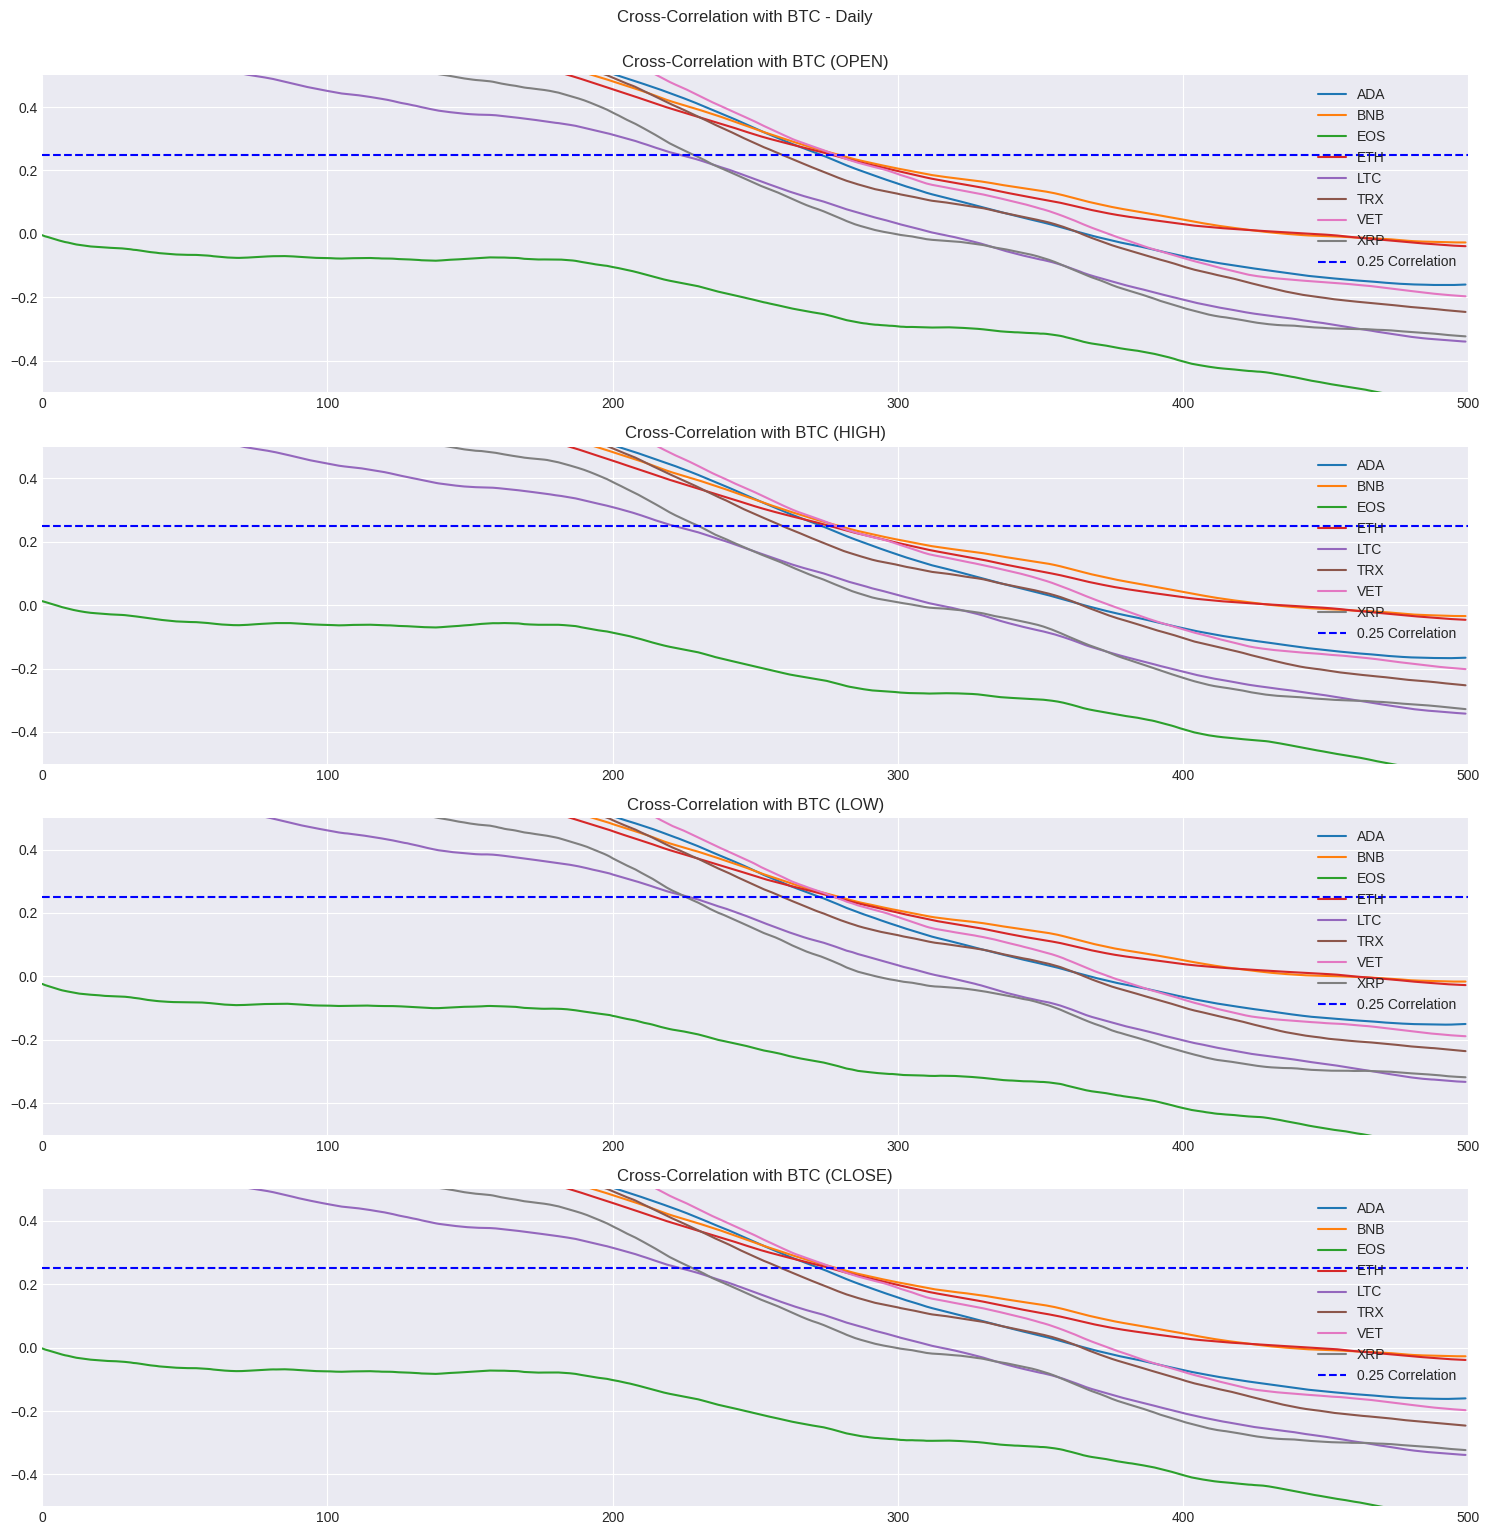

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a function to compute cross-correlation
def cross_correlation(df1, df2, nlags):
    return [df1.corr(df2.shift(i)) for i in range(nlags)]

# Plot cross-correlation with BTC for all other currencies
def plot_cross_correlation(data_dict, time_frame, nlags=500):
    features = ['open', 'high', 'low', 'close']
    symbols = list(data_dict.keys())
    symbols.remove("BTC")

    fig, axes = plt.subplots(nrows=len(features), figsize=(15, 15))

    for ax, feature in zip(axes, features):
        btc_series = data_dict["BTC"][feature]
        for symbol in symbols:
            series = data_dict[symbol][feature]
            ccf = cross_correlation(btc_series, series, nlags)
            ax.plot(ccf, label=symbol)
        
        ax.axhline(0.25, color='blue', linestyle='--', label='0.25 Correlation')
        btc_lag = next((i for i, j in enumerate(ccf) if j > 0.25), len(ccf) - 1)
        
        ax.set_title(f'Cross-Correlation with BTC ({feature.upper()})')
        ax.legend(loc='upper right')
        ax.set_xlim([0, nlags])
        ax.set_ylim([-0.5, 0.5])  # Set y-limit to visualize correlations better

    plt.tight_layout()
    plt.suptitle(f'Cross-Correlation with BTC - {time_frame}', y=1.02)
    plt.show()

# Compute cross-correlation for daily and hourly data
plot_cross_correlation(daily_data, 'Daily')
